## 대시보드

In [ ]:
%%writefile bandboom.py

import streamlit as st
import pandas as pd
import textwrap
import os, json, math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.api as sm
from matplotlib import font_manager, rc
import platform

# if platform.system() == 'Darwin':  # Mac OS
#     # 시스템 폰트 확인
#     for font in font_manager.findSystemFonts():
#         if "Nanum" in font or "AppleGothic" in font:
#             print(font)
#     # 폰트 지정 (예: AppleGothic)
#     plt.rc('font', family='AppleGothic')
# else:  # Windows
#     font_path = "C:\Windows\Fonts\LG PC.ttf"
#     font_name = font_manager.FontProperties(fname=font_path).get_name()
#     plt.rc('font', family=font_name)

BASE_DIR = os.path.dirname(os.path.abspath(__file__))

# 폰트 상대경로
FONT_PATH = os.path.join("fonts", "LG_PC.ttf")

# 폰트 등록
font_prop = font_manager.FontProperties(fname=FONT_PATH)
font_name = font_prop.get_name()

# matplotlib 기본 폰트로 설정
rc("font", family=font_name)
rc("axes", unicode_minus=False)  # 마이너스 깨짐 방지


# ----------------------------
# 메인 화면 세팅
# ----------------------------


st.title("밴드 붐은 온다")

st.sidebar.header("컴퓨팅 탐색 기말 프로젝트")

toc = {
    "0장. '밴드 붐은 온다'" : ["0.1 밴드 붐은 온다"],
    "1장. 밴드에 대한 이해": ["1.1 밴드란?", "1.2 역사 및 장르"],
    "2장. 데이터로 바라보는 밴드 붐": ["2.1 데이터 읽기", "2.2 음원데이터", "2.3 락페스티벌"],
    "3장. 밴드 붐은 무엇을 시사하는가": ["3.1 시사점"],
    "4장. 밴드 음악 추천": ["4.1 음악 추천"]
}

# ----------------------------
# 데이터 설명
# ----------------------------


def read_prop():
    n1 = 500   # 2020~2024 전체 곡 수
    n2 = 100   # 2025년 11월 곡 수

    k1 = 31   # 2020~2024 록/메탈 곡 수
    k2 = 11   # 2025년 11월 록/메탈 곡 수

    p1 = k1 / n1
    p2 = k2 / n2

    p_pool = (k1 + k2) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    z = (p1 - p2) / se if se != 0 else float("nan")
    alpha = 0.05
    df_test = pd.DataFrame({
        "항목": [
            "표본 크기 (n₁)",
            "표본 크기 (n₂)",
            "성공 횟수 (k₁)",
            "성공 횟수 (k₂)",
            "표본비율 (p₁)",
            "표본비율 (p₂)",
            "합동표본비율 (p̂)",
            "표준오차 (SE)",
            "검정통계량 (z)",
            "유의수준 (α)"
        ],
        "값": [
            n1,
            n2,
            k1,
            k2,
            round(p1, 3),
            round(p2, 3),
            round(p_pool, 3),
            round(se, 4),
            round(z, 3),
            alpha
        ],
        "설명": [
            "2020~2024년 전체 곡 수",
            "2025년 11월 전체 곡 수",
            "2020~2024년 록/메탈 곡 수",
            "2025년 11월 록/메탈 곡 수",
            "k₁ / n₁",
            "k₂ / n₂",
            "(k₁ + k₂) / (n₁ + n₂)",
            "√[ p̂(1−p̂)(1/n₁ + 1/n₂) ]",
            "(p₁ − p₂) / SE",
            "검정 기준"
        ]
    })
    st.markdown("**⁉️ 두 모비율의 비교를 위한 z-검정 요약표**")
    st.dataframe(df_test, use_container_width=True)



# ----------------------------
# 음원데이터 시각화
# ----------------------------

# json 파일에서 록/메탈 곡 수 뽑아내기
def load_rockmetal_count(json_path: str) -> int:
    """
    JSON 구조: {"artist - title": {"songId": "...", ...}, ...}
    - songId가 비어있는 항목은 제외하고 카운트
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    k = 0
    for _, v in data.items():
        if isinstance(v, dict) and str(v.get("songId", "")).strip() != "":
            k += 1
    return k


def build_year_count_df(file_map: dict, n_per_year: int = 100):
    """
    file_map 예:
    {2020:"rock_metal_2020_11.json", ..., 2025:"rock_metal_2025_11.json"}
    """
    rows = []
    for year, path in file_map.items():
        if not os.path.exists(path):
            raise FileNotFoundError(f"파일이 없어요: {path}")

        k = load_rockmetal_count(path)
        rows.append({"year": year, "rock_metal_count": k, "n_total": n_per_year})

    df = pd.DataFrame(rows).sort_values("year").reset_index(drop=True)
    return df

#--------------------------

# 모비율 z-검정 (단측 검정)
def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def two_prop_ztest(k1, n1, k2, n2, alternative="greater"):
    """
    두 모비율 z-검정
    H0: p1 = p2
    alternative="greater"는 H1: p1 > p2
    """
    p1 = k1 / n1
    p2 = k2 / n2
    p_pool = (k1 + k2) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))
    z = (p1 - p2) / se

    if alternative == "greater":
        pval = 1 - norm_cdf(z)
    elif alternative == "less":
        pval = norm_cdf(z)
    else:  # two-sided
        pval = 2 * (1 - norm_cdf(abs(z)))

    return p1, p2, z, pval

# 시각화
def plot_two_proportions(df, target_year=2025, baseline_years=(2020, 2021, 2022, 2023, 2024), n_per_year=100):
    """
    - baseline(2020~2024 합산) vs target(2025) 모비율 비교
    - 막대 + 95% CI 에러바
    """
    k_target = int(df.loc[df["year"] == target_year, "rock_metal_count"].values[0])
    n_target = n_per_year

    k_base = int(df[df["year"].isin(baseline_years)]["rock_metal_count"].sum())
    n_base = n_per_year * len(baseline_years)

    p1, p2, z, pval = two_prop_ztest(k_target, n_target, k_base, n_base, alternative="greater")

    # 95% CI (unpooled 근사)
    z975 = 1.96
    ci_target = z975 * math.sqrt(p1 * (1 - p1) / n_target)
    ci_base = z975 * math.sqrt(p2 * (1 - p2) / n_base)

    fig = plt.figure()
    labels = [f"{min(baseline_years)} ~ {max(baseline_years)}", f"{target_year}"]
    vals = [p2, p1]
    errs = [ci_base, ci_target]

    plt.bar(labels, vals, yerr=errs, capsize=8, color = ["#5d86c9", "#142847"], alpha =0.9)
    plt.ylim(0, max(vals) + 0.15)
    plt.ylabel("록/메탈 곡 수의 비율 (TOP100 기준)")
    plt.title(f"모비율 비교 (단측검정 p={pval:.4g})")
    plt.tight_layout()

    stats = {
        "k_target": k_target, "n_target": n_target, "p_target": p1,
        "k_base": k_base, "n_base": n_base, "p_base": p2,
        "z": z, "p_value": pval
    }
    return fig, stats


#--------------------------
# 회귀분석 (산점도 + 회귀직선)
def plot_regression(df):
    """
    단순회귀: rock_metal_count ~ year
    산점도 + 회귀직선
    """
    x = df["year"].astype(float).values
    y = df["rock_metal_count"].astype(float).values

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    yhat = model.predict(X)

    fig = plt.figure()
    plt.scatter(x, y, color = "#93c4a2")
    plt.plot(x, yhat, color = "#054217")
    plt.xlabel("연도")
    plt.ylabel("록/메탈 곡 수 (TOP 100)")
    plt.title(f"회귀직선\n기울기={model.params[1]:.3f}, R²={model.rsquared:.3f}, F p={model.f_pvalue:.4g}")
    plt.tight_layout()

    stats = {
        "beta0": model.params[0],
        "beta1": model.params[1],
        "r2": model.rsquared,
        "f": model.fvalue,
        "f_pvalue": model.f_pvalue
    }
    return fig, stats


# -------------------------
# (3) t-test
def plot_ttest(df, cut_year=2023):
    """
    그룹1: <= cut_year (2020~2023)
    그룹2: >= cut_year+1 (2024~2025)
    Welch t-test + 박스플롯 + 점
    """
    before = df[df["year"] <= cut_year]["rock_metal_count"].values
    after = df[df["year"] >= (cut_year + 1)]["rock_metal_count"].values

    # Welch t-test (등분산 가정 X), 단측: after > before
    t_stat, p_val = ttest_ind(after, before, equal_var=False, alternative="greater")

    order = [f"~{cut_year}", f"{cut_year+1}~"]
    data = [before, after]

    fig = plt.figure()
    plt.boxplot(data, labels=order, showfliers=False)

    # 개별 점
    for i, y in enumerate(data, start=1):
        x = i + (np.random.rand(len(y)) - 0.5) * 0.08
        plt.scatter(x, y, color = "#2e1169")

    plt.ylabel("록/메탈 곡 수 (TOP 100)")
    plt.title(f"t-검정(단측)\np={p_val:.4g}  (after > before)")
    plt.tight_layout()

    stats = {
        "mean_before": float(np.mean(before)),
        "mean_after": float(np.mean(after)),
        "t": float(t_stat),
        "p_value": float(p_val),
        "n_before": int(len(before)),
        "n_after": int(len(after))
    }
    return fig, stats

# ----------------------------
# 락페스티벌 관람객 수 회귀분석
# ----------------------------  

def penta_regression(df, predict_year = 2026):
    x = df["year"].astype(float).values
    y = df["visitor"].astype(float).values

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    yhat = model.predict(X)

    x_new = np.array([2026.0])      # shape (1,)
    X_new = sm.add_constant(x_new, has_constant='add')   # shape (1, 2)

    y_pred_2026 = model.predict(X_new)[0]

    fig = plt.figure()
    plt.scatter(x, y, label="관측값", color = "#37547a")
    plt.plot(x, yhat, label="회귀직선", color = "#1c2945")

    plt.scatter(predict_year, y_pred_2026, color="#752b2b", zorder=5, label="2026년 예측")
    plt.axvline(predict_year, linestyle="--", color="#ab8787", alpha=0.5)

    plt.xlabel("연도")
    plt.ylabel("인천 펜타포트 락페스티벌 참가자 수")
    plt.title(
        f"회귀직선: 기울기={model.params[1]:.1f}, "
        f"R²={model.rsquared:.3f}, F p={model.f_pvalue:.4g}"
    )
    plt.legend()
    plt.tight_layout()

    stats = {
        "beta0": model.params[0],
        "beta1": model.params[1],
        "r2": model.rsquared,
        "f": model.fvalue,
        "f_pvalue": model.f_pvalue,
        "pred_2026": y_pred_2026
    }

    return fig, stats

# ----------------------------
# 섹션별 내용 함수
# ----------------------------

def section_0_1():
    st.write("""
    ### 컴퓨팅 탐색 기말 프로젝트
    2024-13880 이원재

    **주제 : 밴드 붐은 왔는가?**
    """)
    img_path = os.path.join("finalexam", "images", "img3.jpg")
    st.image(img_path, caption="밴드 붐은 온다")      
    # st.image("finalexam/images/img3.jpg", caption="밴드 붐은 온다")
    st.write("""
    불과 몇 년 전까지만해도 록은 비주류 장르였으나, 팬데믹 이후 공연 및 페스티벌 업계가 되살아나면서 상황이 바뀌었습니다.
    인천 펜타포트 락페스티벌은 15만석 전석 매진을 기록했고, 밴드 실리카겔의 멜론뮤직어워즈 무대, 한국대중음악상 수상 등 밴드 음악의 열풍이 이어지고 있습니다.
    이외에도 잔나비, 한로로, QWER, 데이식스 등 다수의 밴드가 국내 페스티벌 라인업에 포함된 모습을 볼 수 있습니다.
    이러한 흐름을 보면, 락은 주류로 진입하는 분기점에 다다른 듯합니다.


    이와 관련해 2024년즈음부터, 우리나라 음악계에서 서동요 기법처럼 **밴드 붐은 온다**는 말이 통용됐습니다.
    이는 밴드 음악의 부흥을 바라는 사람들의 염원을 담은 유행어로 해석할 수 있습니다.
    
    
    이제 여기서 생각해보아야 할 점은, **실제로 밴드 붐이 왔는가**입니다.


    이에 현 대시보드에서는 밴드 음악에 대해 간략히 소개하고, 정말로 **밴드 붐이 왔는지**에 대해 다양한 데이터로 확인해보고자 합니다.
    """)

    st.caption("""
    **출처**

    유승상, '밴드 붐은 온다? 아니 왔다!', 국립한국교통대신문, 2025.10.06

    유영서, “9월의 문화 2018 펜타포트 락페스티벌 - ‘락알못’의 락페 탐방기_일상을 잊고 달리는 환희와 열정의 순간” 유레카,(418), 10-13. 2018, 9. 

    장준환, “[일사일언] "밴드 붐은 온다"” 조선일보, 2024.05.06, https://www.chosun.com/culture-life/culture_general/2024/05/06/ZMDHVFOX2JF6ZGHPZX5M5SMWXY/
    """)

    

def section_1_1():
    st.header("1.1 밴드란?")

    col1, col2 = st.columns(2)
    with col1:
        img_path1 = os.path.join("finalexam", "images", "img1.jpg")
        st.image(img_path1, caption="펜타포트 방문 사진_1")
        # st.image("finalexam/images/img1.jpg", caption="펜타포트 방문 사진_1")
    with col2:
        img_path2 = os.path.join("finalexam", "images", "img2.jpg")
        st.image(img_path2, caption="펜타포트 방문 사진_2")
        # st.image("finalexam/images/img2.jpg", caption="펜타포트 방문 사진_2")
    
    st.markdown("#### 🎸 밴드")
    st.write("""
    밴드(band)는 음악을 연주하는 단체인 ‘악단’을 일컫는 말입니다.  
    록 밴드 뿐만 아니라 오케스트라, 브라스 밴드, 보컬 밴드, 팝 밴드, 보이 밴드 등 악단 전반을 가리키는 말이어서,  
    ‘musical group’과 ‘musical band’나 의미에 큰 차이가 없습니다.
    그러나 한국어에 외래어로 들어온 ‘밴드’는 보통 록이나 메탈 밴드만을 가리키는 경우가 많습니다.  
    즉, 일렉 기타, 베이스 기타, 키보드, 드럼의 구성인 록, 메탈 밴드를 일반적으로 떠올립니다.
    
    **현 대시보드에서는 '록/메탈' 장르를 기준으로 밴드 음악을 설명합니다.**
    """)
    st.caption("출처 : 나무위키 ‘밴드’")

def section_1_2():
    st.header("1.2 역사 및 장르")
    st.write("""
    밴드 음악은 긴 역사와 다양한 장르를 가지고 있습니다. 
    이 페이지에서 역사/장르에 대한 간략한 설명과 관련 영상을 시청하세요.
    """)

    st.subheader("⌛ 역사")
    st.write("""
    록 음악은 단순한 음악 장르가 아니라 **문화, 삶의 태도, 청년 정체성**을 대표하는 음악으로 등장했습니다.
    아래는 간단한 록의 역사를 기술한 것입니다.

    1. 로큰롤의 탄생 (1950년대)
    - 흑인 블루스 + 백인 컨트리 음악의 결합
    - 대표 인물 : 엘비스 프레슬리, 척 베리, 리틀 리처드

    2. 브리티시 인베이전 (1960년대)
    - 미국 로큰롤의 침체 이후, 영국 밴드들이 미국 시장을 장악
    - 대표 : 비틀즈, 롤링 스톤스

    3. 록의 분화와 증식 (1970년대 이후)
    - 록은 하나의 양식에 머무르지 않고 끊임없이 하위 장르로 분화되며 확장
    """)

    st.markdown("**[Youtube] 10분만에 보는 락의 역사&변천사 (1950s ~2000s)**")
    st.video("https://youtu.be/uiDCaUwb_1Y?si=XsMjVlzu4sUopt2o")

    st.subheader("🌟 장르")
    st.write("""
    밴드(록/메탈) 장르는 매우 다양하고 각 장르에 해당하는 음악을 명확하게 구분하기 어려운 특징을 가지고 있습니다.

    대표적인 록 장르를 아래 몇 가지 소개하겠습니다.

    1. 사이키델릭 록 (Psychedelic Rock)
    - 몽환적, 환각적 분위기
    - 약물 경험과 의식 확장 표현

    2. 프로그레시브 록 (Progressive Rock)
    - 록에 복잡한 화성과 구조를 접목
    - 콘셉트 앨범과 사운드 실험이 특징

    3. 하드 록 / 헤비 메탈 (Hard Rock / Heavy Metal)
    - 강력한 기타 리프, 폭발적인 사운드
    - 고함치는 보컬, 고난도 기타 연주

    4. 펑크 록 (Punk Rock)
    - 록의 엘리트주의에 대한 강한 반발
    - 단순한 코드 반복, 빠른 리듬
    - 사회, 정치, 경제 질서에 대한 조롱과 공격

    5. 모던 록 / 그런지 / 브릿팝 (Modern Rock 계열)
    - 물질만능주의, 엘리트 주의 비판
    - 1990년대 이후 언더그라운드 중심
    """)
    
    col1, col2 = st.columns(2)
    with col1:
        st.markdown("**[Youtube] 밴드잘알 당신도 될 수 있다**")
        st.video("https://youtube.com/embed/YMnX8fMPAxQ?si=ha8Y5FdSkERw5w9p")
    with col2:
        st.markdown("**[Youtube] 한국 밴드로 메탈 장르 종류 알아보기☠️**")
        st.video("https://youtube.com/embed/YSY9WTOC9UY?si=w--x-bzApcgtsvyV")

    st.markdown("---")
    st.caption("📁 데이터 출처 : 음악과 사회(이서현) 강의 자료")


def section_2_1():
    st.header("2.1 데이터 읽기")
    st.write("""
    이 대시보드는 총 2가지 데이터,\n
    **음원 데이터**, **락페스티벌 관람객 수**를 기반으로 모비율 검정, 회귀분석, t-검정 등을 수행합니다.\n
    이후 각 분석 및 검정 결과를 그래프로 시각화한 뒤, 결과를 분석합니다.
    """)

    st.markdown("---")

    st.subheader("📊 데이터 분석 방법")
    st.markdown("#### 🎵 음원 데이터")
    st.markdown("""
    멜론 2020년부터 2024년까지 연간 TOP 100 차트, 그리고 2025년 11월 월간 차트 중 록/메탈 장르 곡들의 정보를 Selenium을 활용해 가져와 json파일로 저장한 뒤 분석에 활용합니다.
    
    json 파일 형식은 아래와 같습니다.
    """)
    st.json({
        "한로로 - 사랑하게 될 거야": {
        "artist": "한로로",
        "title": "사랑하게 될 거야",
        "genre": "인디음악, 록/메탈",
        "albumId": "10923444",
        "songId": "36730261"
    },
    "DAY6 (데이식스) - 한 페이지가 될 수 있게": {
        "artist": "DAY6 (데이식스)",
        "title": "한 페이지가 될 수 있게",
        "genre": "록/메탈",
        "albumId": "10923444",
        "songId": "31927275"
    }
    })
    st.caption("rock_metal_2025_11.json 中 일부")

    st.markdown("""
    위의 json 파일 5개(rock_metal_2020.json ~ rock_metal_2025_11.json)을 활용하여 모비율 검정, 회귀분석, t-검정을 수행합니다.
    """)
    st.markdown("""
    1. **모비율 검정**
       - 2020년부터 2024년까지의 록/메탈 곡 수의 비율과 2025년 11월 록/메탈 곡수의 비율을 비교하는 검정을 수행합니다.
       - 이를 통해 록/메탈 곡 수가 지난 시기(2020~2024년)과 비교하여 최근(2025년 11월)에 통계적으로 유의미하게 증가하였는지 확인합니다.
       - 통계적으로 유의미하게 증가하였다면, 위의 분석 결과는 밴드 붐이 왔다는 것을 뒷받침하는 근거가 될 수 있습니다.

    2. **회귀 분석**  
       - 단순히 2020~2024년, 2025년 11월 두 집단으로 쪼개서 보기보다는,
       - 어떻게 록/메탈 곡 수가 증가/감소해왔는지 그 추이를 산점도로 파악하고, 회귀모형을 통해 증가/감소 기울기를 알아보고자 합니다.
       - 회귀모형의 기울기에 대한 추론을 통해 신뢰구간을 구하고, 직선관계의 유의성을 확인하기 위해 결정계수를 활용한 F검정을 진행합니다.
       - 만약 직선관계가 통계적으로 유의미하다고, 기울기가 양수라면, 위의 분석 결과는 밴드 붐이 왔다는 것을 뒷받침하는 근거가 될 수 있습니다.

    3. **두 모평균에 대한 t-검정**  
       - 산점도를 파악해 두 집단으로 분류하고, 두 집단의 모평균에 대한 t-검정을 실시합니다. 
       - 이표본 t-검정을 통해 2024-2025년에 통계적으로 유의미하게 록/메탈 곡 수가 증가한 것이 맞는지 확인합니다. 
       - 통계적으로 유의미하게 증가하였다면, 위의 분석 결과는 밴드 붐이 왔다는 것을 뒷받침하는 근거가 될 수 있습니다.
    """)

    st.markdown("#### 🕺 락페스티벌 관람객 수")
    st.markdown("""
    펜타포트 락페스티벌 2019, 2022, 2023, 2024, 2025년 관람객수를 통해 관람객 수가 증가/감소하였는지 확인하고, 
    2026년 관람객 수까지 회귀분석을 활용하여 예측해보고자 합니다.
    """)
    st.warning("2021, 2022년에는 코로나로 인해 페스티벌이 온라인으로 진행되었으므로 관람객 수 이상치가 발생해 해당 연도 데이터를 제외하였습니다")
       
    st.markdown("---")

    st.markdown("#### 💡 분석 결과의 의의")
    st.info("""
    - 음원데이터, 펜타포트 관람객 수 자료를 통계적 검정 방법으로 분석함으로써 분석 결과의 신뢰도를 높일 수 있음.
    - Selenium을 통한 동적 웹크롤링으로 강의 내용을 적절히 활용함.
    - 데이터 시각화를 streamlit 대시보드에 업로드함으로써 강의 내용을 적절히 활용함.
    """)





def section_2_2():
    st.header("2.2 음원데이터")

    file_map = {
        2020: os.path.join(BASE_DIR, "rock_metal_2020.json"),
        2021: os.path.join(BASE_DIR, "rock_metal_2021.json"),
        2022: os.path.join(BASE_DIR, "rock_metal_2022.json"),
        2023: os.path.join(BASE_DIR, "rock_metal_2023.json"),
        2024: os.path.join(BASE_DIR, "rock_metal_2024.json"),
        2025: os.path.join(BASE_DIR, "rock_metal_2025_11.json"),
    }

    # 파일 존재 체크
    missing = [p for p in file_map.values() if not os.path.exists(p)]
    if missing:
        st.error("아래 파일이 bandboom.py와 같은 폴더에 없어요:\n\n- " + "\n- ".join(missing))
        return

    df = build_year_count_df(file_map, n_per_year=100)

    st.subheader("📆 연도별 록/메탈 곡 수")
    st.dataframe(df, use_container_width=True)
    st.markdown("**아래 세 가지 탭에서 위 데이터 분석 결과를 확인하세요**")

    tab1, tab2, tab3 = st.tabs(["1) 모비율 검정", "2) 회귀분석", "3) t-검정"])

    with tab1:
        st.subheader("모비율 검정")
        st.markdown("""
        - 2020년부터 2024년까지의 록/메탈 곡 수의 비율과 2025년 11월 록/메탈 곡수의 비율을 비교하는 검정을 수행합니다. 
        - 이를 통해 록/메탈 곡 수가 지난 시기(2020~2024년)과 비교하여 최근(2025년 11월)에 통계적으로 유의미하게 증가하였는지 확인합니다. 
        - 통계적으로 유의미하게 증가하였다면, 위의 분석 결과는 밴드 붐이 왔다는 것을 뒷받침하는 근거가 될 수 있습니다.
        """)
        fig, stats = plot_two_proportions(df, target_year=2025, baseline_years=(2020,2021,2022,2023,2024), n_per_year=100)
        st.pyplot(fig)
        plt.close(fig)
        st.write("검정 결과(숫자):")
        st.json(stats)

        read_prop()

        st.markdown("##### 📌 모비율(z-검정) 결과 요약")
        prop_counts = {
            "연도/월": ["2020", "2021", "2022", "2023", "2024", "2025_11"],
            "록/메탈 곡 수 (TOP100 기준)": [7, 6, 5, 4, 9, 11]
        }
        st.dataframe(prop_counts, use_container_width=False)

        # 핵심 수치 요약 (metric)
        c1, c2, c3 = st.columns(3)
        c1.metric("p(2020~2024년)", "0.0620", "k=31 / n=500")
        c2.metric("p(2025년 11월)", "0.1100", "k=11 / n=100")
        c3.metric("차이 (p(2025년 11월) - p(2020~2024년))", "0.0480", "증가")

        st.markdown("""
        **가설 설정**
        - **귀무가설(H₀)**: p₁ = p₂  (2020~2024의 비율 = 2025년 11월의 비율)
        - **대립가설(H₁)**: p₁ < p₂  (2025년 11월의 비율이 더 큼)
        """)

        st.markdown("""
        **[두 모비율 z-검정 결과]**
        - pooled p = **0.0700**
        - SE = **0.027950**
        - z = **1.7174**
        - p-value (one-sided, H₁: 2025 > 2020~2024) = **0.0429571**
        """)

        st.success("p-value < 0.05 이므로, 유의수준 5%에서 귀무가설(H₀)을 기각합니다.\n→ 2025년 11월의 록/메탈 비율이 2020~2024년 대비 유의미하게 증가했습니다.")

        st.markdown("""
        비율 차이: p(2025_11) − p(2020~2024)
        - diff = 0.0480
        - 95% CI ≈ [-0.0169, 0.1129]
        """)
        
        st.markdown("##### ✍️ 해석")
        st.info("""
        - 2025년 11월 TOP100에서 록/메탈 곡 수 비율이 2020~2024년의 평균적 비율보다 **통계적으로 유의미하게 높게 관측**되었습니다.
        - 이를 바탕으로 **최근 밴드/록 음악이 더 주목받고 있을 가능성**을 제시할 수 있으며, “밴드 붐이 왔다”는 가설을 뒷받침하는 근거가 될 수 있습니다.
        """)

        st.markdown("---")

        st.caption("📁 데이터 출처: 멜론(Melon) 차트")    

    with tab2:
        st.subheader("회귀분석")
        st.markdown("""
        - 단순히 2020~2024년과 2025년 11월을 두 집단으로만 비교하면, **시간 흐름에 따른 증가/감소 추이**를 파악하기 어렵습니다.  
        - 이에 연도별(월별) 록/메탈 곡 수의 변화를 **산점도로 확인**하고, **최소제곱법(OLS)**으로 **추정회귀직선**을 그려
          연도에 따른 증가/감소 경향(기울기)을 확인합니다.
        - 또한 **기울기(회귀모수) 유의성 검정**과 **결정계수(R²), F-검정**을 통해 직선 관계가 통계적으로 유의한지 판단합니다.
        """)

        st.markdown("##### 📌 사용 데이터 (연도별/월별 록/메탈 곡 수, TOP100 기준)")
        reg_counts = {
            "연도/월": ["2020", "2021", "2022", "2023", "2024", "2025_11"],
            "록/메탈 곡 수 (TOP100 기준)": [7, 6, 5, 4, 9, 11]
        }
        st.dataframe(reg_counts, use_container_width=False)

        st.markdown("""
        **[단순선형회귀]**
        - **설명변수(X)**: 연도(year)
        - **반응변수(Y)**: 록/메탈 곡 수(rock_metal_count)
        - **유의수준(α)**: 0.05
        - **귀무가설(H₀)**: 기울기(β₁) = 0  (연도와 곡 수 사이에 선형 관계가 없다)
        """)

        # 시각화 + 결과
        fig, stats = plot_regression(df)
        st.pyplot(fig)
        plt.close(fig)

        st.write("회귀 결과(핵심):")
        st.json({
            "기울기(beta1)": float(stats["beta1"]),
            "절편(beta0)": float(stats["beta0"]),
            "R²": float(stats["r2"]),
            "F": float(stats["f"]),
            "F p-value": float(stats["f_pvalue"])
        })

        # 핵심 지표 metric
        c1, c2, c3 = st.columns(3)
        c1.metric("기울기 β₁", f'{stats["beta1"]:.3f}')
        c2.metric("R²", f'{stats["r2"]:.3f}')
        c3.metric("F p-value", f'{stats["f_pvalue"]:.4g}')

        st.markdown("##### 🔎 분석 결과")
        st.markdown(f"""
        - 회귀모형에서 기울기(β₁)는 **{stats["beta1"]:.3f}**이며, 이에 대한 **p-value**는 **{stats["f_pvalue"]:.4g}** 입니다.  
        - **유의수준 0.05**와 비교했을 때 p-value가 더 크므로, **기울기는 통계적으로 유의미하지 않습니다.**
        - 결정계수(R²)는 **{stats["r2"]:.3f}**로 0에 비교적 가깝고, **F-검정**의 유의확률 또한 **{stats["f_pvalue"]:.4g}**로 유의하지 않습니다.
        - 따라서 **귀무가설(H₀)을 기각하지 못합니다.**
        """)

        st.markdown("##### ✍️ 해석")
        st.info("""
        - 본 회귀분석 결과만으로는 **연도와 록/메탈 곡 수 사이에 유의한 선형 관계가 있다고 말하기 어렵습니다.**
        - 이는 (앞선) **이표본 모비율 검정 결과와는 다른 결론**을 보입니다.
        """)

        st.markdown("""
        **한계 및 원인**
        - 산점도를 보면 2020~2023년에는 감소하다가 2024년에 급격히 증가하고 2025년까지 증가하는 형태로,
          단순한 직선(선형)보다는 **비선형적**인 모습을 보입니다.
        - 따라서 이 데이터에서는 **단순 선형회귀만으로 추세를 설명하기 어렵다**는 한계가 있으며,
          회귀분석 외의 다른 검정/모형을 함께 적용해 볼 필요가 있습니다.
        """)

        st.markdown("---")
        st.caption("📁 데이터 출처: 멜론(Melon) 차트")

    with tab3:
        st.subheader("t-검정")

        st.markdown("""
        - 산점도 및 회귀분석 결과, 2020~2023년까지는 록/메탈 곡 수가 감소하다가  
          2024년 이후 증가하는 양상이 관측되었습니다.
        - 이에 연도를 기준으로 두 집단으로 나누어,  
          **2024년 이후의 록/메탈 곡 수 평균이 이전보다 증가하였는지** 확인하고자
          이표본 t-검정을 수행합니다.
        """)

        st.markdown("""
        **가설 설정**
        - **귀무가설(H₀)** : 두 집단의 모평균이 같다.
        - **대립가설(H₁)** : 2024년도 이후 집단의 모평균이 더 크다.
        - **유의수준(α)** : 0.05
        """)

        # t-test 실행 + 시각화
        fig, stats = plot_ttest(df, cut_year=2023)
        st.pyplot(fig)
        plt.close(fig)

        st.write("검정 결과(숫자):")
        st.json(stats)

        # 핵심 지표 강조
        c1, c2 = st.columns(2)
        c1.metric("검정통계량(t)", f'{stats["t"]:.6f}')
        c2.metric("p-value", f'{stats["p_value"]:.6f}')

        st.markdown("##### 🔎 분석 결과")
        st.markdown("""
        - 검정통계량의 값 = **3.7807562268756265**
        - p-value = **0.03438823104650807**
        """)

        st.success("""
        유의확률이 약 3%로 유의수준 0.05보다 작기 때문에  
        **귀무가설을 기각하고 대립가설을 받아들입니다.**
        """)

        st.markdown("##### ✍️ 해석")
        st.markdown("""\
        즉, 2024년 이후의 곡 수 평균이 증가하였으므로  
        멜론 음원 데이터 상으로 **‘밴드 붐’은 2024년 사이 찾아왔다고 말할 수 있습니다.**
        """)

        st.markdown("---")
        st.caption("📁 데이터 출처: 멜론(Melon) 차트")


def section_2_3():
    st.header("2.3 락페스티벌 관람객 수")
    
    st.subheader("🕺락페스티벌")
    st.markdown("""
    펜타포트 락페스티벌 관람객 수 회귀분석을 통해  
    관람객 수가 어느 정도의 기울기로 증가하고 있는지 알아보고,  
    회귀모형을 활용하여 **2026년 펜타포트 락페스티벌 관람객 수를 예측**하고자 합니다.

    이에 증가/감소 추이를 산점도로 파악하고,  
    최소제곱법을 통해 추정회귀직선을 그린 뒤,  
    회귀모형의 기울기에 대한 추론과 결정계수를 활용한 **F-검정**을 수행합니다.

    만약 직선관계가 통계적으로 유의미하고,  
    기울기가 양수라면 위의 분석 결과는 **밴드 붐이 왔다는 것을 뒷받침하는 근거**가 될 수 있습니다.
    """)

    st.markdown("##### 📊 펜타포트 락페스티벌 연도별 관람객 수")
    penta = {
        "year": [2025, 2024, 2023, 2022, 2019],
        "visitor": [166000, 150000, 150000, 130000, 95000]
    }
    penta_df = pd.DataFrame(penta)
    st.dataframe(penta_df, use_container_width=True)

    st.markdown("""
    **단순선형회귀**
    - **설명변수(X)** : 연도(year)
    - **반응변수(Y)** : 펜타포트 락페스티벌 관람객 수
    - **유의수준(α)** : 0.05
    - **귀무가설(H₀)** : 기울기(year 회귀모수) = 0
    """)

    # 회귀분석 실행
    fig, stats = penta_regression(penta_df)
    st.pyplot(fig)
    plt.close(fig)

    st.write("회귀 결과(핵심):")
    st.json(stats)

    # 핵심 지표 강조
    c1, c2, c3 = st.columns(3)
    c1.metric("기울기", f'{stats["beta1"]:.0f}')
    c2.metric("R²", f'{stats["r2"]:.3f}')
    c3.metric("F p-value", f'{stats["f_pvalue"]:.4g}')

    st.markdown("##### 🔎 분석 결과")
    st.markdown("""
    - 추정회귀직선의 기울기는 **1.172×10⁴**로, 연도가 증가함에 따라 관람객 수가 증가하는 경향을 보입니다.
    - 검정통계량(t값)은 **10.840**, 이에 대한 **유의확률은 약 0.002**로 유의수준 0.05보다 매우 작습니다.
    - 결정계수는 **0.975**, 수정결정계수는 **0.967**이며  
      F값은 **117.5**, 이에 대한 p-value는 **0.00168**로 통계적으로 유의미합니다.
    """)

    st.success("""
    위의 결과에 따라 **귀무가설을 기각**할 수 있으며,  
    설명변수(연도)가 반응변수(관람객 수)를 충분히 설명하고 있는  
    **잘 적합된 회귀모형**이라고 말할 수 있습니다.
    """)

    st.markdown("##### 👨‍💻 예측 결과")
    st.markdown(f"""
    - 위의 회귀모형을 활용해 2026년 관람객 수를 예측하면  
      **약 {stats["pred_2026"]:,.0f}명**이라는 값을 얻을 수 있습니다.
    """)

    st.markdown("##### ✍️ 해석")
    st.info("""
    즉, 펜타포트 락페스티벌 관람객 수는 지속적으로 증가하고 있으며,  
    해당 회귀모형은 통계적으로 유의미하기 때문에  
    **락페스티벌 관람객 수를 통해서도 ‘밴드 붐이 왔다’는 점을 설명할 수 있습니다.**
    """)

    st.markdown("---")
    st.caption("""
    📁 데이터 출처  
    - 인천광역시(2025), 인천펜타포트 음악축제 20주년 보도자료  
    - 더아이엔씨(The ICN), 인천 펜타포트 음악축제 관련 기사  
    - 인천투데이, 인천 펜타포트 음악축제 보도  
    - 경향신문 스포츠경향(2022), 펜타포트 락 페스티벌 관련 기사  
    - 경기일보(2019), 인천 펜타포트 락 페스티벌 관람객 보도
    """)


def section_3_1():
    st.header("3.1 시사점")
    st.subheader("🤔 밴드 붐 의의")
    st.write("""
    **‘밴드 붐이 온다’에 대해 이해하는 것**은 다음과 같은 여러 가지 의의를 가집니다.

    ---

    #### 1. 문화 현상을 직접 검증한다는 점

    주관적으로 “요즘 밴드 음악이 다시 유행하는 것 같다”고 느끼는 인상을  
    양적인 데이터 자료를 통해 구체화하고 검증함으로써,  
    해당 담론을 보다 **정확하고 설득력 있는 주장**으로 전환할 수 있습니다.

    즉, 개인의 체감에 머무르지 않고  
    문화 현상을 경험적으로 검토할 수 있다는 점에서 중요한 의미를 가집니다.

    ---

    #### 2. ‘붐’이 발생한 시점을 파악할 수 있다는 점

    음원 데이터를 활용하면  
    어느 시점부터 밴드 음악이 차트 상에서 증가하기 시작했는지를 확인할 수 있으며,  
    이를 통해 하위 문화의 **변동 시점**을 파악할 수 있습니다.

    이는 밴드 음악이 단순히 ‘유행한다’는 표현을 넘어,  
    **언제부터, 어떤 방식으로 변화했는지**를 분석할 수 있게 합니다.

    ---

    #### 3. 밴드 음악이 가지는 사회적 중요성을 이해할 수 있다는 점

    음악은 단순히 개인의 감정에 영향을 주는 데 그치지 않고,  
    인간의 행동과 감정에 바람직한 변화를 일으키며  
    사회적 교류 수단으로서 구체적인 역할을 수행합니다.

    맥카시에 따르면,  
    감정은 사회적 과정에 의해 형성되며  
    ‘감정적 삶’에 사회적 중요성을 부여하는 행위자들과 집단들에 의해 생성되는 **사회적 대상**입니다.

    또한 뒤르켐(Durkheim)은  
    사회 또는 공동체가 함께 모여 같은 생각과 행동에 참여하는 과정에서  
    **집합적 감정**이 형성되고, 이것이 집단 통합에 기여한다고 설명합니다.  

    콜린스(Collins)는  
    고도의 상호주관성이 감정적 합류와 결합되면서  
    소속감, 열정과 같은 **감정적 에너지**로 귀결된다고 말합니다.

    즉, 참여자들이 감정적·인지적 체험을 공유하는 합류 과정을 통해  
    집단 유대, 소속감, 자신감, 열정과 같은 감정적 에너지가 생성되며,  
    이는 유대의 감정을 산출하는 기반이 됩니다.

    ---

    #### 4. 종합적 의의

    이러한 점에서 밴드 음악은 단순한 청각적 경험에 머물지 않고,  
    음악을 매개로 형성된 감정과 사회적 과정을 통해  
    **공동체적 연결을 가능하게 하는 문화적 장치**라고 할 수 있습니다.

    따라서 ‘밴드 붐’에 대해 논의하는 것은  
    사회 속 하위 문화를 보다 구체적으로 이해하는 작업이며,  
    음악을 매개로 한 사회적 과정과 감정을 탐구함으로써  
    궁극적으로는 **사회 집단에 대한 이해로 확장될 수 있다는 의의**를 가집니다.
    """)


    st.caption("""
    **출처**

    문선혜. "음악치료의 이해와 적용에 관한 연구." 국내석사학위논문 중앙대학교 교육대학원, 2003. 서울

    하홍규. “감정, 삶, 사회 ― 감정 사회학 이론들”, 세계정치, 29(0), 109-157. 2018
    """)

def section_4_1():
    st.header("4.1 음악 추천")
    st.subheader("🎶 밴드 음악 추천")
    st.write("프로젝트를 마무리하며, 주제와 관련해 개인적으로 좋아하는 밴드 음악들을 몇 곡 소개하고자 합니다.")

    st.markdown("---")
    st.markdown("**Green day - Jesus Of Suburbia**")
    st.video("https://youtu.be/lPLvBO_2Gn0?si=Fec13rTe8aFpFe2q")

    st.markdown("---")
    st.markdown("**김뜻돌 - 꿈에서 걸려온 전화**")
    st.video("https://youtu.be/NFuhikCmvkw?si=SbWDnrOIcc4dcllH")

    st.markdown("---")
    st.markdown("**SPYAIR - サムライハート(Some Like it Hot)**")
    st.video("https://youtu.be/FgFnOK1wgu8?si=3vRQrL8fLwMREjVc")

    st.markdown("---")
    st.markdown("**Sum 41 - Still Waiting**")
    st.video("https://youtu.be/qO-mSLxih-c?si=Iio9bPO1jEc9kIPp")

    st.markdown("---")
    st.markdown("**Oasis - Champagne Supernova**")
    st.video("https://youtu.be/JmWvnoW7qKE?si=28cEC5_f7wESGbeW")
    
    

# ----------------------------
# 목차 매핑
# ----------------------------
toc_function = {
    "0.1 밴드 붐은 온다" : section_0_1,
    "1.1 밴드란?": section_1_1,
    "1.2 역사 및 장르": section_1_2,
    "2.1 데이터 읽기": section_2_1,
    "2.2 음원데이터": section_2_2,
    "2.3 락페스티벌": section_2_3,
    "3.1 시사점": section_3_1,
    "4.1 음악 추천": section_4_1,
}

# 선택 저장용 변수 초기값
selected = "0.1 밴드 붐은 온다"

st.sidebar.header("🎸 목차")

for chapter, sections in toc.items():
    st.sidebar.markdown(f"### {chapter}")  # 챕터 제목
    for sec in sections:
        if st.sidebar.button(sec, key=sec):  # 각 섹션을 버튼으로 표시
            selected = sec

# ----------------------------
# 본문 표시
# ----------------------------
toc_function[selected]()   # 선택된 함수 실행




Overwriting bandboom.py


,year,audience
0,2025,166000
1,2024,150000
2,2023,150000
3,2022,130000
4,2019,95000


## 웹크롤링 세팅

In [ ]:
!pip install selenium
!pip install chromedriver-autoinstaller

멜론차트>TOP100>멜론


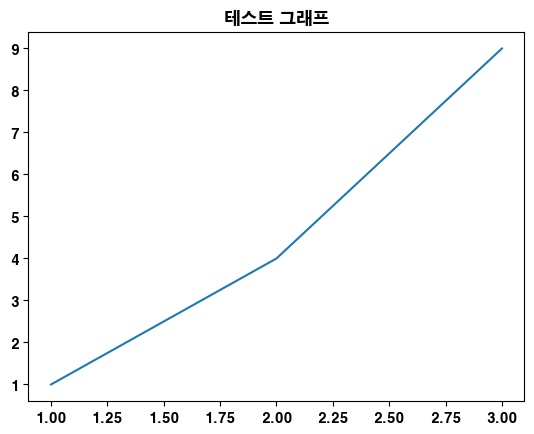

In [138]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import platform

if platform.system() == 'Darwin':  # Mac OS
    # 시스템 폰트 확인
    for font in font_manager.findSystemFonts():
        if "Nanum" in font or "AppleGothic" in font:
            print(font)
    # 폰트 지정 (예: AppleGothic)
    plt.rc('font', family='AppleGothic')
else:  # Windows
    font_path = "C:/Windows/Fonts/H2GTRE.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    plt.rc('font', family=font_name)

# 테스트 그래프
plt.plot([1,2,3],[1,4,9])
plt.title("테스트 그래프")
plt.show()

## 웹크롤링

In [105]:
from selenium import webdriver
import chromedriver_autoinstaller
from selenium.webdriver.chrome.options import Options

chromedriver_autoinstaller.install()

opts = Options()
# opts.add_argument("--headless=new") 
opts.add_argument("--disable-gpu")
opts.add_argument("--window-size=1920,1080")

driver = webdriver.Chrome(options=opts)
url = "https://www.melon.com/chart/index.htm"
driver.get(url)
driver.implicitly_wait(3)
print(driver.title)

멜론차트>TOP100>멜론


In [106]:
from selenium.webdriver.common.by import By
chartfinder_xpath = '//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button'
driver.find_element(By.XPATH, value = chartfinder_xpath).click()
driver.implicitly_wait(3)

테스트

In [100]:
# 2024년
chart_month = driver.find_element(By.CLASS_NAME,'tab03').click()
driver.implicitly_wait(3)
decade_2020 = driver.find_element(By.CSS_SELECTOR, 'label[for="decade_1"]').click()
driver.implicitly_wait(3)
year_2024 = driver.find_element(By.CSS_SELECTOR, 'label[for="year_1"]').click()
driver.implicitly_wait(3)
genre = driver.find_element(By.CSS_SELECTOR, 'label[for="gnr_1"]').click()
driver.implicitly_wait(3)

find_xpath = '//*[@id="d_srch_form"]/div[2]/button'
driver.find_element(By.XPATH, value = find_xpath).click()
driver.implicitly_wait(3)


In [ ]:
import time, re

rock_metal_2024_test = {}

rows = driver.find_elements(By.CSS_SELECTOR, 'tr[id^="lst"]')

for i in range(len(rows)):
    rows = driver.find_elements(By.CSS_SELECTOR, 'tr[id^="lst"]')
    row = rows[i]

    title = row.find_element(By.CSS_SELECTOR, 'div.ellipsis.rank01 a').text.strip()
    artist = row.find_element(By.CSS_SELECTOR, 'div.ellipsis.rank02 a').text.strip()
    
    album = row.find_element(By.CSS_SELECTOR, 'div.ellipsis.rank03 a')
    href = album.get_attribute("href")
    album_id = re.search(r"goAlbumDetail\('(\d+)'\)", href).group(1)

    driver.get(f"https://www.melon.com/album/detail.htm?albumId={album_id}")
    time.sleep(1.0)

    genre_text = driver.find_element(By.XPATH, '//dt[contains(., "장르")]/following-sibling::dd[1]').text.strip()

    if "록/메탈" in genre_text:
        key = f"{artist} - {title}"
        rock_metal_2024_test[key] = {"artist": artist, "title": title, "genre": genre_text, "albumId": album_id}

    driver.back()
    time.sleep(1.0)

print("록/메탈 곡 수:", len(rock_metal_2024_test))

록/메탈 곡 수: 16


In [ ]:
rock_metal_2024_test

In [ ]:
import pandas as pd

rows = []
for key, v in rock_metal_2024.items():
    rows.append({
        "key": key,
        "artist": v.get("artist", ""),
        "title": v.get("title", ""),
        "genre": v.get("genre", ""),
        "albumId": v.get("albumId", "")
    })

df = pd.DataFrame(rows)

df.to_csv("rock_metal_2024.csv", index=False, encoding="utf-8-sig")

print("저장 완료:", len(df), "rows")

저장 완료: 16 rows


총 5년간의 연간 차트 데이터 수집

In [ ]:
import time, re, json
from selenium.webdriver.common.by import By

rock_metal_all = {}  

for year in [1, 2, 3, 4, 5]:  
    print(f"\n=== {2025-year} 시작 ===")
    driver.get('https://www.melon.com/chart/search/index.htm')

    driver.find_element(By.CLASS_NAME, 'tab03').click()
    time.sleep(3)

    driver.find_element(By.CSS_SELECTOR, 'label[for="decade_1"]').click()
    time.sleep(1)

    driver.find_element(By.CSS_SELECTOR, f'label[for="year_{year}"]').click()
    time.sleep(1)

    driver.find_element(By.CSS_SELECTOR, 'label[for="gnr_1"]').click()
    time.sleep(1)

    driver.find_element(By.XPATH, '//*[@id="d_srch_form"]/div[2]/button').click()
    time.sleep(2)

    songs = []
    rows = driver.find_elements(By.CSS_SELECTOR, 'tr[id^="lst"]')
    for row in rows:
        title = row.find_element(By.CSS_SELECTOR, 'div.ellipsis.rank01 a').text.strip()
        artist = row.find_element(By.CSS_SELECTOR, 'div.ellipsis.rank02 a').text.strip()
        href = row.find_element(By.CSS_SELECTOR, 'a.btn.btn_icon_detail').get_attribute("href")
        song_id = re.search(r"goSongDetail\('(\d+)'\)", href).group(1)
        songs.append((song_id, title, artist))

    print("차트 수집 곡 수:", len(songs))

    rock_metal = {}
    for song_id, title, artist in songs:
        driver.get(f"https://www.melon.com/song/detail.htm?songId={song_id}")
        time.sleep(1)

        genre_text = driver.find_element(
            By.XPATH, '//dt[contains(., "장르")]/following-sibling::dd[1]'
        ).text.strip()

        if "록/메탈" in genre_text:
            key = f"{artist} - {title}"
            rock_metal[key] = {"artist": artist, "title": title, "songId": song_id, "genre": genre_text}

    rock_metal_all[2025-year] = rock_metal
    print("록/메탈 곡 수:", len(rock_metal))

    with open(f"rock_metal_{2025-year}.json", "w", encoding="utf-8") as f:
        json.dump(rock_metal, f, ensure_ascii=False, indent=2)


print("\n완료!")

2025년 11월 차트 데이터

In [ ]:
# 2025년 11월 차트 데이터
from selenium.webdriver.common.by import By
import time, re

chartfinder_xpath = '//*[@id="gnb_menu"]/ul[1]/li[1]/div/div/button'
driver.find_element(By.XPATH, value = chartfinder_xpath).click()
driver.implicitly_wait(3)

chart_month = driver.find_element(By.CLASS_NAME,'tab02').click()
driver.implicitly_wait(3)
decade_2020 = driver.find_element(By.CSS_SELECTOR, 'label[for="decade_1"]').click()
driver.implicitly_wait(3)
year_2024 = driver.find_element(By.CSS_SELECTOR, 'label[for="year_1"]').click()
driver.implicitly_wait(3)
month_11 = driver.find_element(By.CSS_SELECTOR, 'label[for="month_11"]').click()
driver.implicitly_wait(3)
genre = driver.find_element(By.CSS_SELECTOR, 'label[for="gnr_1"]').click()
driver.implicitly_wait(3)

find_xpath = '//*[@id="d_srch_form"]/div[2]/button'
driver.find_element(By.XPATH, value = find_xpath).click()
driver.implicitly_wait(3)


rock_metal_2025_11 = {}

rows = driver.find_elements(By.CSS_SELECTOR, 'tr[id^="lst"]')

for i in range(len(rows)):
    rows = driver.find_elements(By.CSS_SELECTOR, 'tr[id^="lst"]')
    row = rows[i]

    title = row.find_element(By.CSS_SELECTOR, 'div.ellipsis.rank01 a').text.strip()
    artist = row.find_element(By.CSS_SELECTOR, 'div.ellipsis.rank02 a').text.strip()
    
    href = row.find_element(By.CSS_SELECTOR, 'a.btn.btn_icon_detail').get_attribute("href")
    song_id = re.search(r"goSongDetail\('(\d+)'\)", href).group(1)
    
    driver.get(f"https://www.melon.com/song/detail.htm?songId={song_id}")
    time.sleep(1)

    genre_text = driver.find_element(By.XPATH, '//dt[contains(., "장르")]/following-sibling::dd[1]').text.strip()
    time.sleep(1.2)

    if "록/메탈" in genre_text:
        key = f"{artist} - {title}"
        rock_metal_2025_11[key] = {
            "artist": artist,
            "title": title,
            "genre": genre_text,
            "albumId": album_id,
            "songId": song_id
        }

    driver.back()
    time.sleep(1.0)

with open(f"rock_metal_2025_11.json", "w", encoding="utf-8") as f:
        json.dump(rock_metal_2025_11, f, ensure_ascii=False, indent=2)

print("록/메탈 곡 수:", len(rock_metal_2025_11))


록/메탈 곡 수: 11


In [120]:
# json 마지막 파일에서 songID로 소실된 title, artist 찾기

from selenium.webdriver.common.by import By
import re

target_song_id = "39117090"

rows = driver.find_elements(By.CSS_SELECTOR, 'tr[id^="lst"]')

found = False

for row in rows:
    href = row.find_element(By.CSS_SELECTOR, 'a.btn.btn_icon_detail') \
              .get_attribute("href")

    m = re.search(r"goSongDetail\('(\d+)'\)", href)
    if not m:
        continue

    song_id = m.group(1)

    if song_id == target_song_id:
        # ✅ 이 row가 우리가 찾는 마지막 곡
        title_elem = row.find_element(By.CSS_SELECTOR, 'div.ellipsis.rank01 a')
        artist_elems = row.find_elements(By.CSS_SELECTOR, 'div.ellipsis.rank02 a')

        title = title_elem.text.strip() or title_elem.get_attribute("title")
        artist = " / ".join(
            a.text.strip() or a.get_attribute("title")
            for a in artist_elems
        )

        print("🎯 찾음!")
        print("songId :", song_id)
        print("title  :", title)
        print("artist :", artist)

        found = True
        break

if not found:
    print("❌ 차트 100곡 안에서 해당 songId를 찾지 못함")

🎯 찾음!
songId : 39117090
title  : 눈물참기 재생 - 새창
artist : QWER - 페이지 이동 / QWER - 페이지 이동


## 파이썬 내 데이터 분석 및 시각화

### 데이터 분석

In [ ]:
# 두 모비율의 비교를 위한 검정
# 2020~2024년 록/메탈 장르 곡 수의 비율과 2025년 11월 곡 수의 비율을 비교하여 최근 록/메탈 붐이 일어난 것인지 확인하고자 함
# python을 통한 모비율 검정 방법을 알기 위해 chatGPT 이용

import json
import math
from pathlib import Path

# ---------------------------
# (A) JSON에서 록/메탈 곡 수(k) 세기
# ---------------------------
def count_rockmetal(json_path: str) -> int:
    """
    JSON 파일 구조가 { "artist - title": { ... }, ... } 형태라고 가정.
    길이(len)가 곡 수이긴 한데, 혹시 빈 항목이 섞였을 때를 대비해
    songId가 있는 항목만 세도록 안전하게 작성.
    """
    data = json.loads(Path(json_path).read_text(encoding="utf-8"))
    k = 0
    for _, v in data.items():
        # v가 dict이고 songId가 있으면 곡으로 인정
        if isinstance(v, dict) and str(v.get("songId", "")).strip() != "":
            k += 1
    return k

files = {
    2020: "rock_metal_2020.json",
    2021: "rock_metal_2021.json",
    2022: "rock_metal_2022.json",
    2023: "rock_metal_2023.json",
    2024: "rock_metal_2024.json",
    "2025_11": "rock_metal_2025_11.json",
}

k = {year: count_rockmetal(fname) for year, fname in files.items()}

print("연도별(월별) 록/메탈 곡 수 k (TOP100 기준):")
for year, kk in k.items():
    print(" ", year, ":", kk)

# 분모(전체 곡 수): TOP100이므로 연도/월마다 100개라고 가정
n_2025 = 100
n_baseline = 100 * 5  # 2020~2024 총 5년

k_2025 = k["2025_11"]
k_baseline = k[2020] + k[2021] + k[2022] + k[2023] + k[2024]

p_2025 = k_2025 / n_2025
p_baseline = k_baseline / n_baseline

print("\n비율:")
print(f"  2025년 11월: k={k_2025}, n={n_2025}, p={p_2025:.4f}")
print(f"  2020~2024 합: k={k_baseline}, n={n_baseline}, p={p_baseline:.4f}")

# ---------------------------
# (B) 두 모비율 z-검정(정석)
#  - H0: p1 = p2
#  - H1: p1 > p2 (한쪽검정)
# ---------------------------

# 1) 풀드(pooled) 비율: H0 하에서 두 집단이 같은 p라고 가정하니까
p_pool = (k_2025 + k_baseline) / (n_2025 + n_baseline)

# 2) 표준오차(SE): pooled p를 사용
se = math.sqrt(p_pool * (1 - p_pool) * (1 / n_2025 + 1 / n_baseline))

# 3) z 통계량
z = (p_2025 - p_baseline) / se

# 4) p-value 계산(정규분포 상에서 한쪽검정: P(Z >= z))
#    정규분포 CDF는 erf로 계산 가능
def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

p_value_one_sided = 1 - norm_cdf(z)

print("\n[두 모비율 z-검정 결과]")
print(f"  pooled p = {p_pool:.4f}")
print(f"  SE       = {se:.6f}")
print(f"  z        = {z:.4f}")
print(f"  p-value (H1: 2025 > baseline, one-sided) = {p_value_one_sided:.6g}")

# ---------------------------
# (C) 추가로: 비율 차이(2025 - baseline)의 95% 신뢰구간(참고용)
#   - 신뢰구간은 보통 'unpooled' SE를 씀(표본비율 기반)
# ---------------------------
se_unpooled = math.sqrt(p_2025*(1-p_2025)/n_2025 + p_baseline*(1-p_baseline)/n_baseline)
z_975 = 1.959963984540054  # 95% CI용
diff = p_2025 - p_baseline
ci_low = diff - z_975 * se_unpooled
ci_high = diff + z_975 * se_unpooled

print("\n[비율 차이 p2025 - pbaseline]")
print(f"  차이(diff) = {diff:.4f}")
print(f"  95% CI ≈ [{ci_low:.4f}, {ci_high:.4f}]  (참고: unpooled)")


연도별(월별) 록/메탈 곡 수 k (TOP100 기준):
  2020 : 7
  2021 : 6
  2022 : 5
  2023 : 4
  2024 : 9
  2025_11 : 11

비율:
  2025년 11월: k=11, n=100, p=0.1100
  2020~2024 합: k=31, n=500, p=0.0620

[두 모비율 z-검정 결과]
  pooled p = 0.0700
  SE       = 0.027950
  z        = 1.7174
  p-value (H1: 2025 > baseline, one-sided) = 0.0429571

[비율 차이 p2025 - pbaseline]
  차이(diff) = 0.0480
  95% CI ≈ [-0.0169, 0.1129]  (참고: unpooled)


In [123]:
pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.6 MB 3.9 MB/s eta 0:00:03
   -------- ------------------------------- 2.1/9.6 MB 4.0 MB/s eta 0:00:02
   ------------ --------------------------- 2.9/9.6 MB 3.7 MB/s eta 0:00:02
   ---------------- ----------------------- 3.9/9.6 MB 4.0 MB/s eta 0:00:02
   ------------------- -------------------- 4.7/9.6 MB 4.0 MB/s eta 0:00:02
   ------------------------ --------------- 5.8/9.6 MB 4.0 MB/s eta 0:00:01
   --------------------------- ------------ 6.6/9.6 MB 4.0 MB/s eta 0:00:01
   ------------------------------ --------- 7.3/9.6 MB 4.0 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.6 MB 4.0 MB/s eta 0:00:01
   ------------------------------------- -- 8.9/9.6 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 3.8 MB/s  0:00:02

   -------------------------

In [ ]:
# 회귀분석
# 회귀분석을 통하여 기울기를 구하고, 결정계수를 통해 직선관계가 유의한지 판단해보고자 함.
# python을 통한 회귀분석 방법을 알기 위해 chatGPT 이용

import json
import pandas as pd
import statsmodels.api as sm
from pathlib import Path

# ----------------------------
# (1) JSON에서 연도별 록/메탈 곡 수 추출
# ----------------------------
def count_rockmetal(path):
    data = json.loads(Path(path).read_text(encoding="utf-8"))
    return sum(1 for v in data.values() if v.get("songId", "").strip() != "")

years = [2020, 2021, 2022, 2023, 2024, 2025]
files = {
    2020: "rock_metal_2020.json",
    2021: "rock_metal_2021.json",
    2022: "rock_metal_2022.json",
    2023: "rock_metal_2023.json",
    2024: "rock_metal_2024.json",
    2025: "rock_metal_2025_11.json",
}

data = []
for y in years:
    k = count_rockmetal(files[y])
    data.append({"year": y, "rock_metal_count": k})

df = pd.DataFrame(data)
print(df)


   year  rock_metal_count
0  2020                 7
1  2021                 6
2  2022                 5
3  2023                 4
4  2024                 9
5  2025                11


In [125]:
# ----------------------------
# (2) 단순 선형회귀
# ----------------------------
X = df["year"]
Y = df["rock_metal_count"]

X = sm.add_constant(X)   # 절편 포함
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       rock_metal_count   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     1.965
Date:                Sat, 13 Dec 2025   Prob (F-statistic):              0.234
Time:                        22:13:07   Log-Likelihood:                -12.519
No. Observations:                   6   AIC:                             29.04
Df Residuals:                       4   BIC:                             28.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1611.0000   1154.269     -1.396      0.2

c:\Users\LG\OneDrive\바탕 화면\EC_file\venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [130]:
# 산점도가 비선형적으로 나타남
# 이에 2020-2023, 2024-2025로 집단을 구분하여 두 집단 평균 차이를 검정하는 t-test 수행

from scipy.stats import ttest_ind

before = df[df["year"] <= 2023]["rock_metal_count"]
after = df[df["year"] >= 2024]["rock_metal_count"]

t_stat, p_value = ttest_ind(after, before, alternative="greater", equal_var=False)
print(t_stat, p_value)

3.7807562268756265 0.03438823104650807


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

penta = {'2025' : 166000, '2024' : 150000, '2023' : 150000, '2022' : 130000, '2019' : 95000}
penta_df = pd.DataFrame(
    list(penta.items()),
    columns=["year", "visitor"]
    )
print(penta_df)
predict_year=2026
x = penta_df["year"].astype(float).to_numpy()
y = penta_df["visitor"].astype(float).to_numpy()
X = sm.add_constant(x)  # (n,2)
model = sm.OLS(y, X).fit()

yhat = model.predict(X)

x_new = np.array([float(predict_year)])  
X_new = sm.add_constant(x_new, has_constant="add")  
y_pred = float(model.predict(X_new)[0])

print("\n===== OLS Regression Summary =====")
print(model.summary())

print(f"\n===== Prediction =====")
print(f"{predict_year}년 예측 방문자 수: {y_pred:,.0f}")


   year  visitor
0  2025   166000
1  2024   150000
2  2023   150000
3  2022   130000
4  2019    95000

===== OLS Regression Summary =====
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     117.5
Date:                Sun, 14 Dec 2025   Prob (F-statistic):            0.00168
Time:                        15:43:04   Log-Likelihood:                -48.380
No. Observations:                   5   AIC:                             100.8
Df Residuals:                       3   BIC:                             99.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      

c:\Users\LG\OneDrive\바탕 화면\EC_file\venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


### 데이터 시각화

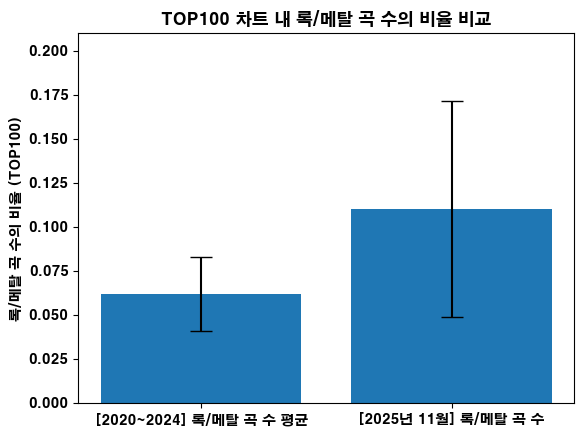

In [128]:
import matplotlib.pyplot as plt
import math

p_2025 = p_2025
p_baseline = p_baseline

n_2025 = 100
n_baseline = 500

z = 1.96
ci_2025 = z * math.sqrt(p_2025 * (1 - p_2025) / n_2025)
ci_baseline = z * math.sqrt(p_baseline * (1 - p_baseline) / n_baseline)

labels = ["[2020~2024] 록/메탈 곡 수 평균", "[2025년 11월] 록/메탈 곡 수"]
proportions = [p_baseline, p_2025]
errors = [ci_baseline, ci_2025]

plt.figure()
plt.bar(labels, proportions, yerr=errors, capsize=8)
plt.ylabel("록/메탈 곡 수의 비율 (TOP100)")
plt.title("TOP100 차트 내 록/메탈 곡 수의 비율 비교")
plt.ylim(0, max(proportions) + 0.1)
plt.show()


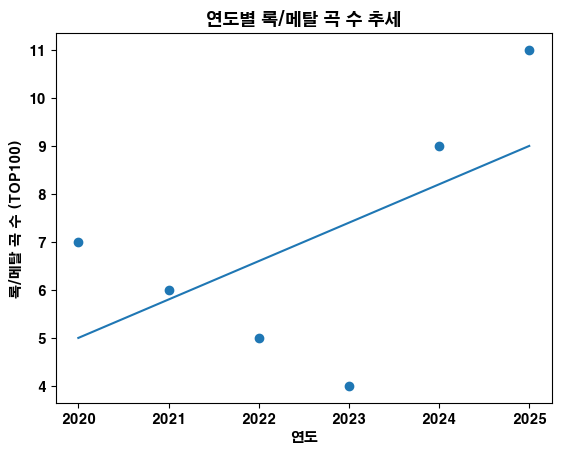

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# df는 앞에서 만든 DataFrame
x = df["year"]
y = df["rock_metal_count"]

# 회귀 직선 값
y_hat = model.predict(sm.add_constant(x))

plt.figure()
plt.scatter(x, y)
plt.plot(x, y_hat)
plt.xlabel("연도")
plt.ylabel("록/메탈 곡 수 (TOP100)")
plt.title("연도별 록/메탈 곡 수 추세")
plt.show()

C:\Users\LG\AppData\Local\Temp\ipykernel_11404\3909235195.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


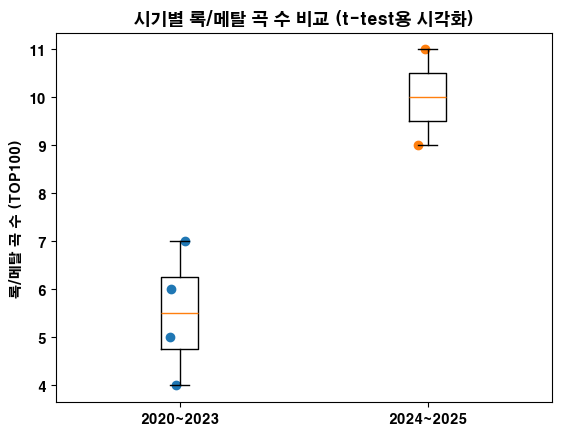

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# df는 위의 회귀분석에서 만든 것 사용
df["period"] = df["year"].apply(lambda y: "2020~2023" if y <= 2023 else "2024~2025")

order = ["2020~2023", "2024~2025"]
data = [df[df["period"] == g]["rock_metal_count"].values for g in order]

plt.figure()

# 박스플롯
plt.boxplot(data, labels=order, showfliers=False)

# 개별 점 
for i, g in enumerate(order, start=1):
    y = df[df["period"] == g]["rock_metal_count"].values
    x = i + (np.random.rand(len(y)) - 0.5) * 0.08
    plt.scatter(x, y)

plt.ylabel("록/메탈 곡 수 (TOP100)")
plt.title("시기별 록/메탈 곡 수 비교 (t-test)")
plt.show()


In [ ]:
# 펜타포트 관람객 수 회귀분석 시각화
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

penta = {'2025' : 166000, '2024' : 150000, '2023' : 150000, '2022' : 130000, '2019' : 95000}
penta_df = pd.DataFrame(
    list(penta.items()),
    columns=["year", "visitor"]
    )
predict_year=2026
x = penta_df["year"].astype(float).to_numpy()
y = penta_df["visitor"].astype(float).to_numpy()
X = sm.add_constant(x)  # (n,2)
model = sm.OLS(y, X).fit()

yhat = model.predict(X)

x_new = np.array([float(predict_year)])  
X_new = sm.add_constant(x_new, has_constant="add")  
y_pred = float(model.predict(X_new)[0])


order = np.argsort(x)
x_sorted = x[order]
yhat_sorted = yhat[order]

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x, y, label="관측값")
ax.plot(x_sorted, yhat_sorted, label="회귀직선")

ax.scatter([predict_year], [y_pred], color="red", zorder=5, label=f"{predict_year}년 예측")
ax.axvline(predict_year, linestyle="--", color="gray", alpha=0.5)

ax.set_xlabel("연도")
ax.set_ylabel("인천 펜타포트 락페스티벌 참가자 수")
ax.set_title(
    f"회귀직선: 기울기={model.params[1]:.1f}, "
    f"R²={model.rsquared:.3f}, F p={model.f_pvalue:.4g}"
)
ax.legend()
fig.tight_layout()

plt.show()

stats = {
    "beta0": float(model.params[0]),
    "beta1": float(model.params[1]),
    "r2": float(model.rsquared),
    "f": float(model.fvalue),
    "f_pvalue": float(model.f_pvalue),
    "pred_year": int(predict_year),
    "pred_value": y_pred,
}
print(stats)


## streamlit 데이터 분석 및 시각화

In [ ]:
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt

# -------------------------
# 설정
# -------------------------
files = {
    2020: "rock_metal_2020.json",
    2021: "rock_metal_2021.json",
    2022: "rock_metal_2022.json",
    2023: "rock_metal_2023.json",
    2024: "rock_metal_2024.json",
    "2025_11": "rock_metal_2025_11.json",
}

# -------------------------
# 유틸 함수
# -------------------------
def load_json(path: str) -> dict:
    return json.loads(Path(path).read_text(encoding="utf-8"))

def count_songs(data: dict) -> int:

    k = 0
    for _, v in data.items():
        if isinstance(v, dict) and str(v.get("songId", "")).strip() != "":
            k += 1
    return k

def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def two_prop_z_test(k1, n1, k2, n2, alternative="greater"):
    """
    두 모비율 z-검정
    - H0: p1 = p2
    - alternative: "greater" (p1 > p2), "two-sided", "less"
    """
    p1 = k1 / n1
    p2 = k2 / n2
    p_pool = (k1 + k2) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))
    z = (p1 - p2) / se

    if alternative == "greater":
        p_value = 1 - norm_cdf(z)
    elif alternative == "less":
        p_value = norm_cdf(z)
    else:  # two-sided
        p_value = 2 * (1 - norm_cdf(abs(z)))

    return {
        "p1": p1, "p2": p2,
        "z": z, "p_value": p_value,
        "p_pool": p_pool, "se_pooled": se
    }

def ols_simple_regression(x, y):
    """
    단순회귀(절편 포함) 결과를 '직접 계산'해서,
    기울기/절편/R^2/F/p-value까지 반환.
    (statsmodels 없이도 동작하게)
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x)

    x_bar = x.mean()
    y_bar = y.mean()

    Sxx = ((x - x_bar) ** 2).sum()
    Sxy = ((x - x_bar) * (y - y_bar)).sum()
    beta1 = Sxy / Sxx
    beta0 = y_bar - beta1 * x_bar

    y_hat = beta0 + beta1 * x
    resid = y - y_hat

    SSE = (resid ** 2).sum()
    SST = ((y - y_bar) ** 2).sum()
    SSR = SST - SSE

    R2 = 1 - SSE / SST if SST != 0 else 0.0

    # F = (SSR/1) / (SSE/(n-2))
    df1 = 1
    df2 = n - 2
    MSE = SSE / df2
    F = (SSR / df1) / MSE

    
    return {
        "beta0": beta0, "beta1": beta1,
        "R2": R2, "F": F, "df1": df1, "df2": df2,
        "y_hat": y_hat
    }

In [ ]:
# -------------------------
# Streamlit UI
# -------------------------
st.set_page_config(page_title="Rock/Metal Trend Dashboard", layout="wide")
st.title("TOP100 차트 내 록/메탈 비중 변화 분석")

st.markdown("""
이 대시보드는 다음을 보여줍니다.

- **두 모비율 검정**: 2025년 11월(Top100) 록/메탈 비율이 2020~2024(합산 Top500)보다 증가했는지  
- **회귀분석(단순 선형회귀)**: 연도 증가에 따라 록/메탈 곡 수가 증가 추세인지(직선 기울기, R², F검정)
""")

with st.sidebar:
    st.header("데이터 설정")
    n_per_period = st.number_input("각 기간의 분모 n (TOP100이면 100)", min_value=1, value=100, step=1)
    alpha = st.slider("유의수준 α", 0.01, 0.10, 0.05, 0.01)
    st.caption("※ 2020~2024는 5개 연도 합산(분모=5×n)으로 비교합니다.")

# -------------------------
# 데이터 로드
# -------------------------
missing = [f for f in DEFAULT_FILES.values() if not Path(f).exists()]
if missing:
    st.error("아래 파일을 app.py와 같은 폴더에 두고 다시 실행해줘:\n\n- " + "\n- ".join(missing))
    st.stop()

data = {k: load_json(v) for k, v in DEFAULT_FILES.items()}
counts = {k: count_songs(data[k]) for k in DEFAULT_FILES.keys()}

st.subheader("연도/월별 록/메탈 곡 수 (JSON 엔트리 기준)")
count_table = pd.DataFrame([
    {"period": str(k), "rock_metal_count": counts[k], "n_total": n_per_period if k=="2025_11" else n_per_period}
    for k in counts.keys()
])
st.dataframe(count_table, use_container_width=True)

# -------------------------
# (1) 두 모비율 검정 + 시각화
# -------------------------
st.header("1) 두 모비율 검정 (2025년 11월 vs 2020~2024 합산)")

k1 = counts["2025_11"]
n1 = n_per_period
k2 = counts[2020] + counts[2021] + counts[2022] + counts[2023] + counts[2024]
n2 = n_per_period * 5

test = two_prop_z_test(k1, n1, k2, n2, alternative="greater")

colA, colB = st.columns(2)
with colA:
    st.metric("2025년 11월 비율 p1", f"{test['p1']:.3f}", help=f"k={k1}, n={n1}")
    st.metric("2020~2024 비율 p2", f"{test['p2']:.3f}", help=f"k={k2}, n={n2}")
with colB:
    st.metric("z 통계량", f"{test['z']:.3f}")
    st.metric("p-value (단측: p1>p2)", f"{test['p_value']:.6f}")
    st.write("판정:", "**유의** ✅" if test["p_value"] < alpha else "**유의하지 않음** ❌", f"(α={alpha})")

# 비율 막대 + 95% CI(unpooled) 시각화
p1 = test["p1"]; p2 = test["p2"]
z975 = 1.96
ci1 = z975 * math.sqrt(p1*(1-p1)/n1)
ci2 = z975 * math.sqrt(p2*(1-p2)/n2)

fig1 = plt.figure()
labels = ["2020–2024", "2025년 11월"]
vals = [p2, p1]
errs = [ci2, ci1]
plt.bar(labels, vals, yerr=errs, capsize=8)
plt.ylabel("록/메탈 비율")
plt.title("록/메탈 비율 비교 (95% CI 포함)")
plt.ylim(0, max(vals) + 0.15)
st.pyplot(fig1)

st.caption("해석 팁: 막대 높이는 관측 비율, 에러바는 95% 신뢰구간(근사)입니다. 유의성은 p-value로 최종 판단하세요.")

# -------------------------
# (2) 회귀분석 + 시각화
# -------------------------
st.header("2) 회귀분석 (연도 → 록/메탈 곡 수)")

years = np.array([2020, 2021, 2022, 2023, 2024, 2025], dtype=float)
y_counts = np.array([counts[2020], counts[2021], counts[2022], counts[2023], counts[2024], counts["2025_11"]], dtype=float)

reg = ols_simple_regression(years, y_counts)

# p-value/F를 정확히 계산하려면 statsmodels+scipy가 제일 편해서,
# 설치되어 있으면 summary로 보여주고, 없으면 숫자만 보여줌.
try:
    import statsmodels.api as sm
    X = sm.add_constant(years)
    model = sm.OLS(y_counts, X).fit()
    st.write("회귀식(추정):  Ŷ = β0 + β1×Year")
    st.metric("기울기 β1", f"{model.params[1]:.4f}", help="연도 1 증가 시 록/메탈 곡 수 변화(곡)")
    st.metric("절편 β0", f"{model.params[0]:.2f}")
    st.metric("R²", f"{model.rsquared:.3f}")
    st.metric("F 통계량", f"{model.fvalue:.3f}")
    st.metric("F 검정 p-value", f"{model.f_pvalue:.6f}")
    st.write("판정:", "**유의** ✅" if model.f_pvalue < alpha else "**유의하지 않음** ❌", f"(α={alpha})")
    y_hat = model.predict(X)
    with st.expander("회귀 결과 요약표 보기 (statsmodels)"):
        st.text(model.summary().as_text())
except Exception:
    st.warning("statsmodels가 없어서(또는 오류) 회귀 요약표 대신 기본 값만 표시합니다. `pip install statsmodels scipy` 권장.")
    st.metric("기울기 β1", f"{reg['beta1']:.4f}")
    st.metric("절편 β0", f"{reg['beta0']:.2f}")
    st.metric("R²", f"{reg['R2']:.3f}")
    st.metric("F", f"{reg['F']:.3f}")
    y_hat = reg["y_hat"]

# 산점도 + 회귀직선
fig2 = plt.figure()
plt.scatter(years, y_counts)
plt.plot(years, y_hat)
plt.xlabel("연도")
plt.ylabel("록/메탈 곡 수 (TOP100)")
plt.title("연도별 록/메탈 곡 수: 산점도 + 회귀직선")
st.pyplot(fig2)

st.caption("해석 팁: 점은 실제 관측값, 선은 회귀가 예측한 평균적 추세입니다. β1>0이고 유의하면 '증가 추세'라고 말할 근거가 됩니다.")


In [ ]:
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# df는 이미 위에서 만든 DataFrame (year, rock_metal_count 컬럼 포함)이라고 가정
df = df.copy()  # 원본 df 건드리지 않게

df["period"] = df["year"].apply(lambda y: "2020~2023" if y <= 2023 else "2024~2025")

order = ["2020~2023", "2024~2025"]
data = [df[df["period"] == g]["rock_metal_count"].values for g in order]

# ✅ Streamlit에서는 fig 객체를 만들어서 st.pyplot(fig)로 출력
fig = plt.figure()

# 박스플롯
plt.boxplot(data, labels=order, showfliers=False)

# 개별 점 (jitter로 겹침 줄이기)
for i, g in enumerate(order, start=1):
    y = df[df["period"] == g]["rock_metal_count"].values
    x = i + (np.random.rand(len(y)) - 0.5) * 0.08
    plt.scatter(x, y)

plt.ylabel("록/메탈 곡 수 (TOP100)")
plt.title("시기별 록/메탈 곡 수 비교 (t-test용 시각화)")

st.pyplot(fig)  # ✅ plt.show() 대신 이거!
plt.close(fig)  # ✅ Streamlit에서 메모리/중복 출력 방지용 (권장)
